In [111]:
import datetime as dtm
import requests
import pandas as pd
import time
import os
import numpy as np
import scipy as sp
import pickle
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import random
import src.data_retriever as intrinio
import src.pso as pso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
%matplotlib inline

In [112]:
seed = int(dtm.datetime.now().timestamp())
random.seed(seed)
datefrom = dtm.datetime(2010, 1, 1)
dateto = dtm.datetime(2019, 3, 1)

In [113]:
#DOW 30
stock_names = ['AAPL', 'CSCO', 'WMT', 'MCD', 'GS', 'AXP', 'BA', 'KO', 'V', 'WMT', 'UNH']
# stock_names = ['AAPL']

In [114]:
stocks_filename = 'stocks_dow30_full.csv'
if os.path.isfile(stocks_filename):
    stocks = pd.read_csv(stocks_filename)
    stocks['date'] = pd.to_datetime(stocks['date'], format="%Y-%m-%d")
else:
    stocks = intrinio.get_stocks_data(stock_names, datefrom, dateto)
    stocks.to_csv(stocks_filename, index_label='id', columns=stocks.columns)

### Подготовка к обучению

In [115]:
train_datefrom = dtm.datetime(2010, 1, 1)
train_dateto = dtm.datetime(2017, 1, 1)

valid_datefrom = train_dateto
valid_dateto = dtm.datetime(2018, 1, 1)

In [116]:
data = stocks.drop(0).reset_index(drop=True).drop('id', axis=1)
data['date'] = data['date'].map(lambda x: x.timestamp())

In [117]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#to_normalize = ['volume_prev1', 'ebitda']
#data['date_norm'] = MinMaxScaler().fit_transform(data['date'].as_matrix().reshape(-1, 1))
#data['volume_prev1'] = MinMaxScaler().fit_transform(data['volume_prev1'].as_matrix().reshape(-1, 1))
#data['ebitda'] = MinMaxScaler().fit_transform(data['ebitda'].as_matrix().reshape(-1, 1))
data['stock_name'] = LabelEncoder().fit_transform(data['stock_name'].as_matrix().reshape(-1, 1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [118]:
train_data = data[data['date'] <= train_dateto.timestamp()]
X_train = train_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_train))
Y_train_regr = train_data['close']
Y_train_classify = train_data['close'] > train_data['open']

49336


In [119]:
valid_data = data[data['date'] > valid_datefrom.timestamp()]
valid_data = valid_data[valid_data['date'] < valid_dateto.timestamp()]
# valid_data = valid_data.query('(stock_name == 0)')
X_valid = valid_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_valid))
Y_valid_classify = valid_data['close'] > valid_data['open']

7028


In [120]:
ts = time.time()

default_model_class = XGBClassifier(seed=seed)

default_model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True,         
        eval_metric='auc',
        early_stopping_rounds = 10)
    
time.time() - ts

[0]	validation_0-auc:0.615554	validation_1-auc:0.599843
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.629031	validation_1-auc:0.612461
[2]	validation_0-auc:0.643176	validation_1-auc:0.626252
[3]	validation_0-auc:0.6628	validation_1-auc:0.639905
[4]	validation_0-auc:0.665915	validation_1-auc:0.644574
[5]	validation_0-auc:0.670284	validation_1-auc:0.651574
[6]	validation_0-auc:0.677803	validation_1-auc:0.658704
[7]	validation_0-auc:0.679087	validation_1-auc:0.660165
[8]	validation_0-auc:0.68301	validation_1-auc:0.665407
[9]	validation_0-auc:0.688727	validation_1-auc:0.670294
[10]	validation_0-auc:0.694339	validation_1-auc:0.674975
[11]	validation_0-auc:0.695836	validation_1-auc:0.677657
[12]	validation_0-auc:0.697036	validation_1-auc:0.679909
[13]	validation_0-auc:0.698267	validation_1-auc:0.681985
[14]	validation_0-auc:0.700608	validation_1-auc:0.683348
[

32.947492837905884

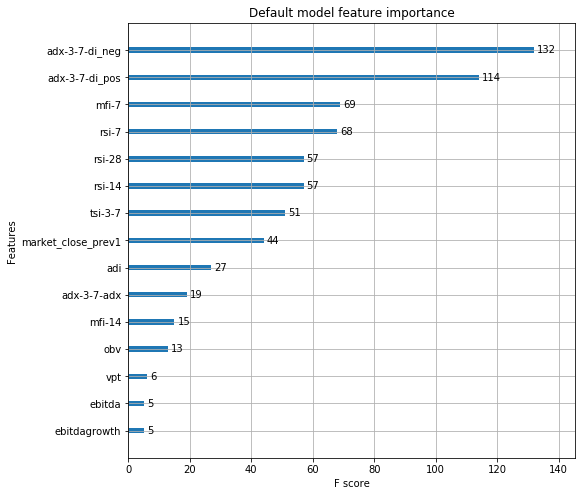

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_importance(booster=default_model_class, ax=ax,title='Default model feature importance', max_num_features=15)

In [122]:
def fitness_class(params):
    params['seed'] = seed
    params['n_jobs'] = 4
    model_class = XGBClassifier(**params)  

    model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)],   
        verbose=False,
        eval_metric='auc',
        early_stopping_rounds = 10)
    return -model_class.best_score

patterns = [
    ("max_depth", int, 1, 50),
    ("n_estimators", int, 10, 10000),
    ("min_child_weight", int, 10, 5000),
    ("colsample_bytree", float, 0.0, 1.0),
    ("subsample", float, 0.1, 1.0),
    ("eta", float, 0.0, 1.0),
]

In [123]:
random.seed(seed)
ts = time.time()
#opt_class, fitness_class_res = pso.optimize(patterns, fitness_class)
time.time() - ts

0.0

In [124]:
# opt_class['seed'] = seed
# opt_class, fitness_class_res

In [125]:
 params_pso_class = {'max_depth': 14,
  'n_estimators': 631,
  'min_child_weight': 308,
  'colsample_bytree': 0.3835295385104849,
  'subsample': 0.8779845029326574,
  'eta': 0.8885150603875441,
  'seed': seed}
# params_pso_class = opt_class
model_pso_class_opt = XGBClassifier(**params_pso_class)
model_pso_class_opt.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)],   
        verbose=True,
        eval_metric='auc',
        early_stopping_rounds = 20)

[0]	validation_0-auc:0.655642	validation_1-auc:0.633536
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.680274	validation_1-auc:0.657326
[2]	validation_0-auc:0.690956	validation_1-auc:0.667994
[3]	validation_0-auc:0.697778	validation_1-auc:0.674228
[4]	validation_0-auc:0.699549	validation_1-auc:0.677291
[5]	validation_0-auc:0.702911	validation_1-auc:0.679955
[6]	validation_0-auc:0.712187	validation_1-auc:0.688229
[7]	validation_0-auc:0.712073	validation_1-auc:0.685189
[8]	validation_0-auc:0.711635	validation_1-auc:0.68304
[9]	validation_0-auc:0.715305	validation_1-auc:0.68642
[10]	validation_0-auc:0.715769	validation_1-auc:0.685232
[11]	validation_0-auc:0.714442	validation_1-auc:0.684337
[12]	validation_0-auc:0.719272	validation_1-auc:0.689907
[13]	validation_0-auc:0.71962	validation_1-auc:0.68792
[14]	validation_0-auc:0.723087	validation_1-auc:0.693553
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3835295385104849, eta=0.8885150603875441,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=14,
       min_child_weight=308, missing=None, n_estimators=631, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1558269237,
       silent=True, subsample=0.8779845029326574)

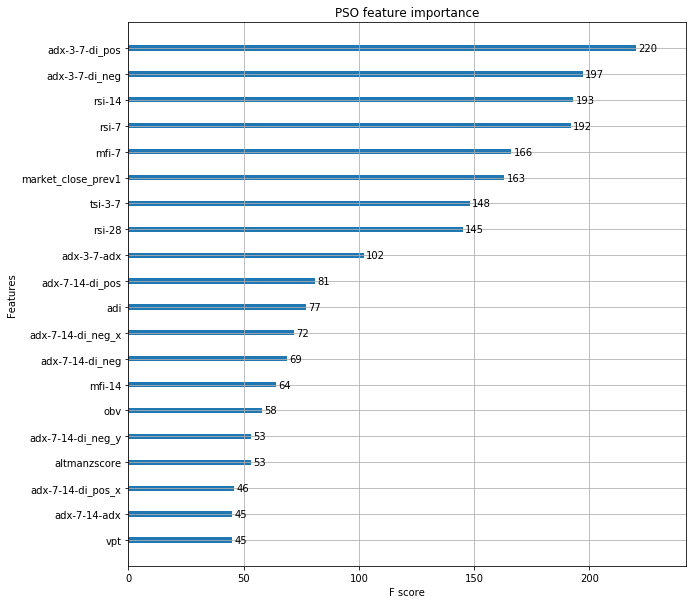

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_importance(booster=model_pso_class_opt, ax=ax, max_num_features=20, title='PSO feature importance')

In [127]:
random.seed(seed)
param_dist = {"max_depth": sp.stats.randint(1, 50),
              "n_estimators": sp.stats.randint(10, 10000),
              "min_child_weight": sp.stats.randint(10, 10000),
              "subsample": sp.stats.uniform(0, 1),
              "colsample_bytree": sp.stats.uniform(0, 1),
              "eta":sp.stats.uniform(0, 1)}
ts = time.time()
# search_classif=RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, scoring="roc_auc", n_jobs=3, verbose=10)
# search_classif.fit(X_train, Y_train_classify)
time.time() - ts

0.0009980201721191406

In [128]:
# search_classif.cv_results_

In [129]:
rscv_opt_class = {
  'colsample_bytree': 0.660990766743628,
  'max_depth': 42,
  'min_child_weight': 791,
  'n_estimators': 5890,
  'seed': seed,
  'subsample': 0.8348475397192338,
  'eta': 0.5027783968770865}

In [130]:
# rscv_opt_class = search_classif.best_estimator_.get_params()
# rscv_opt_class['seed']=seed
# rscv_opt_class, search_classif.best_score_

In [131]:
ts = time.time()
model_rscv_class = XGBClassifier(**rscv_opt_class)

model_rscv_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True,         
        eval_metric='auc',
        early_stopping_rounds = 10)
    
time.time() - ts

[0]	validation_0-auc:0.631145	validation_1-auc:0.615996
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.652714	validation_1-auc:0.636225
[2]	validation_0-auc:0.656313	validation_1-auc:0.639443
[3]	validation_0-auc:0.666403	validation_1-auc:0.652448
[4]	validation_0-auc:0.676671	validation_1-auc:0.659386
[5]	validation_0-auc:0.685824	validation_1-auc:0.670088
[6]	validation_0-auc:0.686671	validation_1-auc:0.671983
[7]	validation_0-auc:0.693026	validation_1-auc:0.676259
[8]	validation_0-auc:0.695182	validation_1-auc:0.67813
[9]	validation_0-auc:0.696995	validation_1-auc:0.680941
[10]	validation_0-auc:0.698389	validation_1-auc:0.680489
[11]	validation_0-auc:0.699762	validation_1-auc:0.683121
[12]	validation_0-auc:0.705517	validation_1-auc:0.688818
[13]	validation_0-auc:0.707837	validation_1-auc:0.690837
[14]	validation_0-auc:0.709097	validation_1-auc:0.692543

[142]	validation_0-auc:0.767176	validation_1-auc:0.736821
[143]	validation_0-auc:0.767261	validation_1-auc:0.736935
[144]	validation_0-auc:0.767409	validation_1-auc:0.736837
[145]	validation_0-auc:0.767562	validation_1-auc:0.736795
[146]	validation_0-auc:0.767712	validation_1-auc:0.73695
[147]	validation_0-auc:0.767833	validation_1-auc:0.737038
[148]	validation_0-auc:0.767939	validation_1-auc:0.737207
[149]	validation_0-auc:0.768082	validation_1-auc:0.737188
[150]	validation_0-auc:0.768282	validation_1-auc:0.737331
[151]	validation_0-auc:0.768427	validation_1-auc:0.737274
[152]	validation_0-auc:0.768384	validation_1-auc:0.737105
[153]	validation_0-auc:0.768563	validation_1-auc:0.737175
[154]	validation_0-auc:0.768696	validation_1-auc:0.737352
[155]	validation_0-auc:0.768742	validation_1-auc:0.73769
[156]	validation_0-auc:0.768883	validation_1-auc:0.737692
[157]	validation_0-auc:0.76894	validation_1-auc:0.737678
[158]	validation_0-auc:0.769199	validation_1-auc:0.73766
[159]	validation_0

77.70423483848572

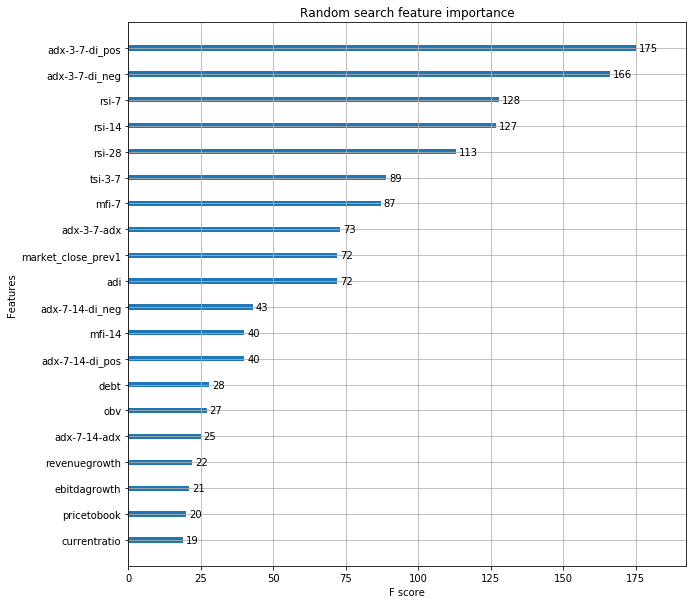

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_importance(booster=model_rscv_class, ax=ax, max_num_features=20, title='Random search feature importance')

In [133]:
random.seed(seed)
param_dist = {"max_depth": [10, 35],
              "n_estimators": [1000, 5500],
              "min_child_weight": [1000, 5500],
              "subsample": [0.2, 0.7],
              "colsample_bytree": [0.5],
              "eta": [0.3]}
ts = time.time()
#grid_search_classif=GridSearchCV(XGBClassifier(), param_grid=param_dist, scoring="roc_auc", n_jobs=3, verbose=10)
#grid_search_classif.fit(X_train, Y_train_classify)
time.time() - ts

0.0

In [134]:
#grid_search_classif.best_estimator_

In [135]:
grid_opt_class = {
  'colsample_bytree': 0.5,
  'max_depth': 10,
  'min_child_weight': 1000,
  'n_estimators': 1000,
  'seed': seed,
  'subsample': 0.7,
  'eta': 0.3}

In [136]:
# grid_opt_class = grid_search_classif.best_estimator_.get_params()
# grid_opt_class['seed']=seed
# grid_opt_class, grid_search_classif.best_score_

In [137]:
ts = time.time()
model_grid_class = XGBClassifier(**grid_opt_class)

model_grid_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True,         
        eval_metric='aucpr',
        early_stopping_rounds = 10)
    
time.time() - ts

[0]	validation_0-aucpr:0.611106	validation_1-aucpr:0.592882
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.641458	validation_1-aucpr:0.620643
[2]	validation_0-aucpr:0.6458	validation_1-aucpr:0.623724
[3]	validation_0-aucpr:0.655894	validation_1-aucpr:0.635536
[4]	validation_0-aucpr:0.672447	validation_1-aucpr:0.651578
[5]	validation_0-aucpr:0.677375	validation_1-aucpr:0.663384
[6]	validation_0-aucpr:0.684123	validation_1-aucpr:0.668147
[7]	validation_0-aucpr:0.686333	validation_1-aucpr:0.673852
[8]	validation_0-aucpr:0.684287	validation_1-aucpr:0.669878
[9]	validation_0-aucpr:0.688189	validation_1-aucpr:0.669611
[10]	validation_0-aucpr:0.690407	validation_1-aucpr:0.673026
[11]	validation_0-aucpr:0.691296	validation_1-aucpr:0.672749
[12]	validation_0-aucpr:0.693271	validation_1-aucpr:0.674719
[13]	validation_0-aucpr:0.693947	validation_1-aucpr:0.6774

[132]	validation_0-aucpr:0.752415	validation_1-aucpr:0.727412
[133]	validation_0-aucpr:0.752672	validation_1-aucpr:0.727455
[134]	validation_0-aucpr:0.752746	validation_1-aucpr:0.727523
[135]	validation_0-aucpr:0.752909	validation_1-aucpr:0.727456
[136]	validation_0-aucpr:0.752987	validation_1-aucpr:0.727283
[137]	validation_0-aucpr:0.753184	validation_1-aucpr:0.727731
[138]	validation_0-aucpr:0.75337	validation_1-aucpr:0.727886
[139]	validation_0-aucpr:0.75346	validation_1-aucpr:0.728098
[140]	validation_0-aucpr:0.753645	validation_1-aucpr:0.728217
[141]	validation_0-aucpr:0.753793	validation_1-aucpr:0.728357
[142]	validation_0-aucpr:0.754025	validation_1-aucpr:0.728517
[143]	validation_0-aucpr:0.754206	validation_1-aucpr:0.728545
[144]	validation_0-aucpr:0.754444	validation_1-aucpr:0.728674
[145]	validation_0-aucpr:0.754685	validation_1-aucpr:0.72886
[146]	validation_0-aucpr:0.754769	validation_1-aucpr:0.728634
[147]	validation_0-aucpr:0.754821	validation_1-aucpr:0.728765
[148]	valid

48.356733083724976

In [138]:
sum(list(Y_valid_classify))/len(list(Y_valid_classify))

0.5153671030165055

In [139]:
from sklearn.metrics import classification_report
print(classification_report(Y_valid_classify, model_grid_class.predict(X_valid)))

              precision    recall  f1-score   support

       False       0.65      0.70      0.67      3406
        True       0.69      0.64      0.67      3622

   micro avg       0.67      0.67      0.67      7028
   macro avg       0.67      0.67      0.67      7028
weighted avg       0.67      0.67      0.67      7028



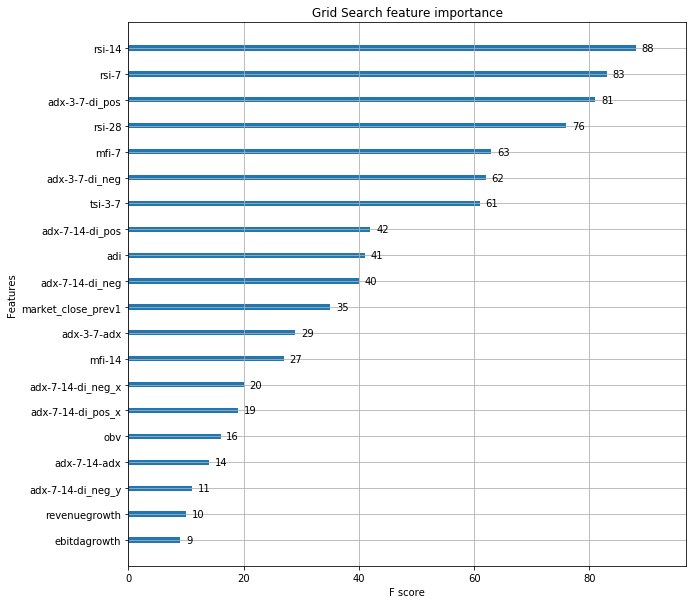

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_importance(booster=model_grid_class, ax=ax, max_num_features=20, title='Grid Search feature importance')